In [1]:
import torch

import denoiser_geometry
import matplotlib.pyplot as plt

In [2]:
n_data_samples = 1000
device = 'cuda'

ambient_dim = 2

lid_class = 1
n_classes = 3

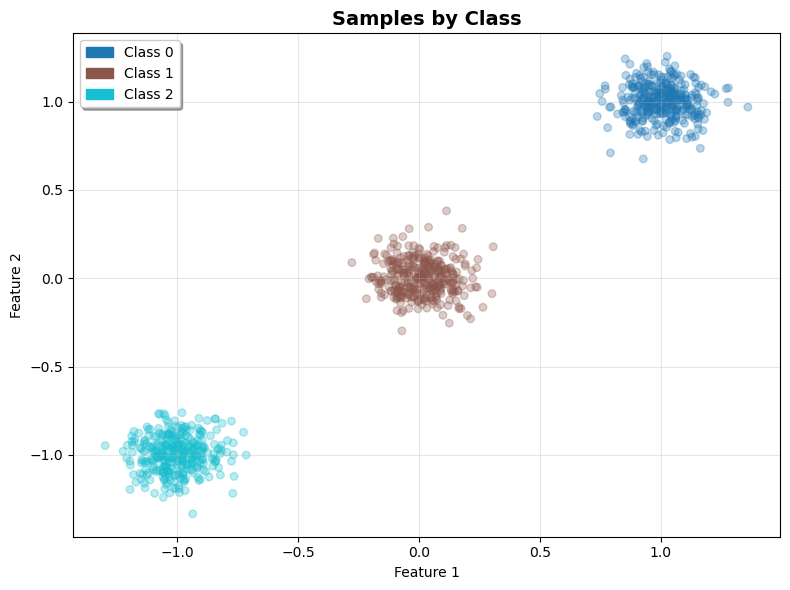

In [3]:
# get data for basic demonstration
data = denoiser_geometry.data.gaussian_mixtures.get_trimodal_set(dim=ambient_dim).sample(n_data_samples)

denoiser_geometry.data.plotting.plot_samples(*data.tensors, kde_sigma=0.02)

In [4]:
## Instantiate a Denoiser
h_dim = 64
model = denoiser_geometry.models.mlp.DiffusionMLP(ambient_dim, hidden_dims=[h_dim] * 4, time_embed_dim=h_dim, class_embed_dim=h_dim, num_classes=3).to(device)
denoiser = denoiser_geometry.methods.flowmatch.FlowMatch(
    model=model,
    ambient_dim=ambient_dim
).to(device)

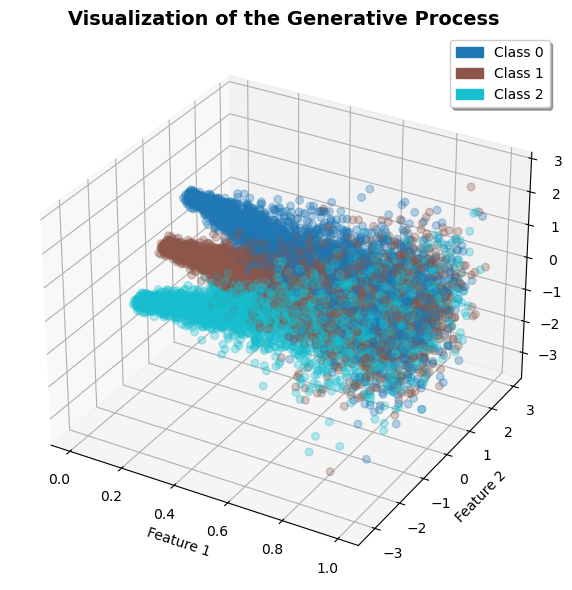

In [9]:
# for t in [0, 1], plot the forward 'diffusion' process
n_subset = 100
x_subset = data.tensors[0][:n_subset]
label_subset = data.tensors[1][:n_subset]

all_x = []
all_label = []
for t in torch.linspace(0., 1., steps=100):
    t = t.expand((n_subset,))
    x_subset_noisy = denoiser.add_noise(x_subset, t)[0]
    all_x.append(torch.cat(
        [t[:, None], x_subset_noisy], dim=1
    ))
    all_label.append(label_subset)

all_x = torch.cat(all_x, dim=0)
all_label = torch.cat(all_label, dim=0)

denoiser_geometry.data.plotting.plot_samples(all_x, all_label, title="Visualization of the Generative Process")

In [6]:
### fit the model to the data
denoiser.train_dsm(data, n_batches=30000, print_every=1000, device=device)

Batch 1000/30000, Loss: 0.276065, LR: 9.97e-04
Batch 2000/30000, Loss: 0.205911, LR: 9.89e-04
Batch 3000/30000, Loss: 0.200671, LR: 9.76e-04
Batch 4000/30000, Loss: 0.193438, LR: 9.57e-04
Batch 5000/30000, Loss: 0.187003, LR: 9.34e-04
Batch 6000/30000, Loss: 0.184170, LR: 9.05e-04
Batch 7000/30000, Loss: 0.177837, LR: 8.73e-04
Batch 8000/30000, Loss: 0.174391, LR: 8.36e-04
Batch 9000/30000, Loss: 0.174670, LR: 7.96e-04
Batch 10000/30000, Loss: 0.172169, LR: 7.52e-04
Batch 11000/30000, Loss: 0.172720, LR: 7.06e-04
Batch 12000/30000, Loss: 0.174108, LR: 6.58e-04
Batch 13000/30000, Loss: 0.170782, LR: 6.08e-04
Batch 14000/30000, Loss: 0.171923, LR: 5.57e-04
Batch 15000/30000, Loss: 0.166738, LR: 5.05e-04
Batch 16000/30000, Loss: 0.167798, LR: 4.53e-04
Batch 17000/30000, Loss: 0.167952, LR: 4.02e-04
Batch 18000/30000, Loss: 0.168050, LR: 3.52e-04
Batch 19000/30000, Loss: 0.168524, LR: 3.04e-04
Batch 20000/30000, Loss: 0.165728, LR: 2.57e-04
Batch 21000/30000, Loss: 0.164617, LR: 2.14e-04
B

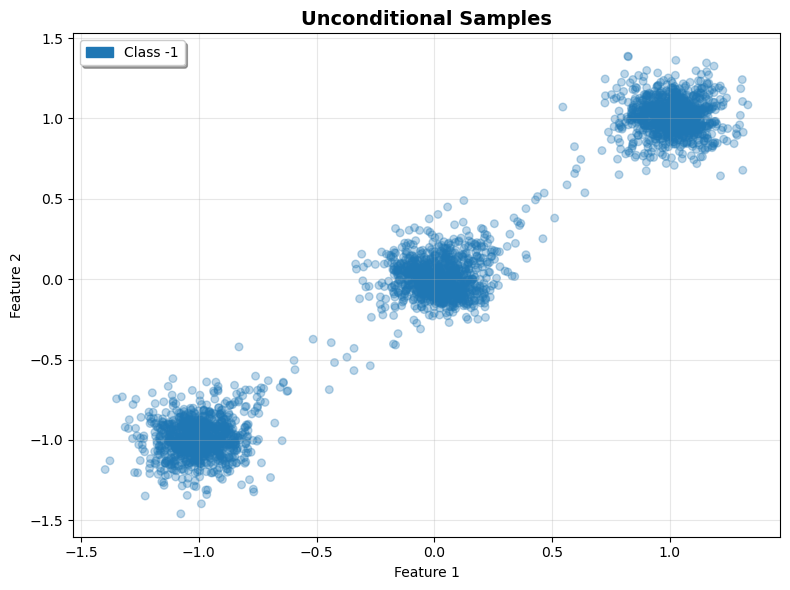

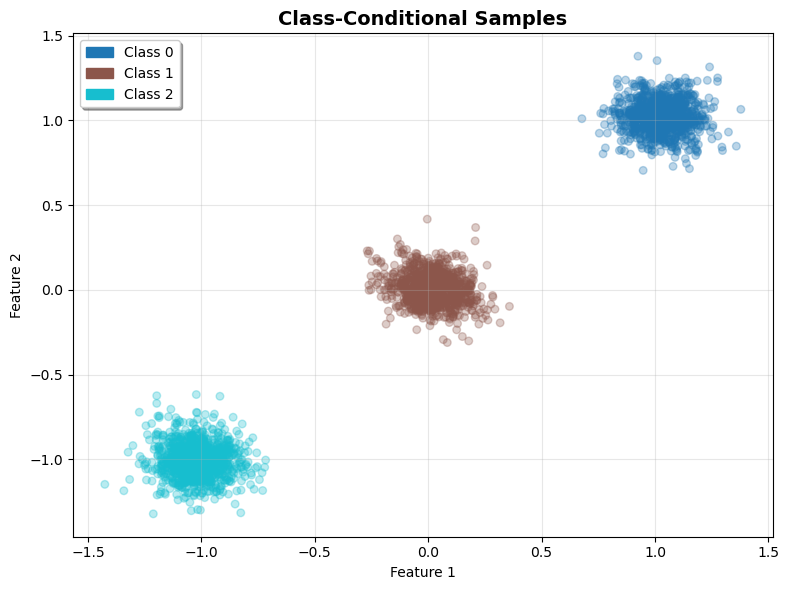

In [7]:
n_gen_samples = 1000
n_steps = 1000
clf_guidance = 1.1
gen_samples = denoiser.deterministic_sample(3*n_gen_samples, class_idx=3, n_steps=n_steps, device=device)
denoiser_geometry.data.plotting.plot_samples(gen_samples, title="Unconditional Samples", kde_sigma=0.02)



gen_samples_0 = denoiser.deterministic_sample(n_gen_samples, class_idx=0, n_steps=n_steps, device=device, clf_guidance=clf_guidance)
gen_samples_1 = denoiser.deterministic_sample(n_gen_samples, class_idx=1, n_steps=n_steps, device=device, clf_guidance=clf_guidance)
gen_samples_2 = denoiser.deterministic_sample(n_gen_samples, class_idx=2, n_steps=n_steps, device=device, clf_guidance=clf_guidance)
gen_samples = torch.cat([gen_samples_0, gen_samples_1, gen_samples_2])
gen_class_idxs = torch.cat([torch.zeros((n_gen_samples,), dtype=int), torch.ones((n_gen_samples,), dtype=int), 2*torch.ones((n_gen_samples,), dtype=int)])
denoiser_geometry.data.plotting.plot_samples(gen_samples, gen_class_idxs, title="Class-Conditional Samples", kde_sigma=0.02)

Text(0, 0.5, 'LID Estimate')

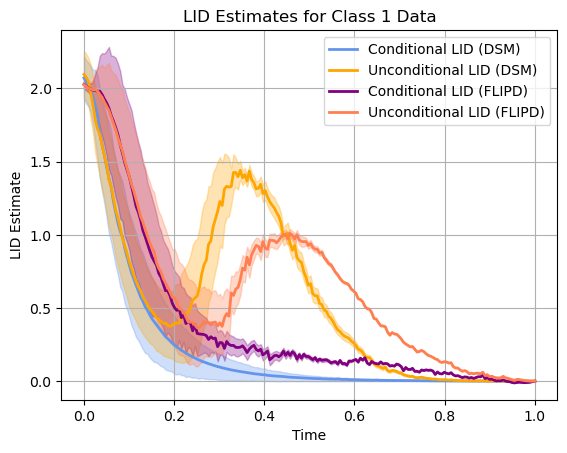

In [8]:
## Plot the LID estimates with time
timesteps = torch.linspace(0., 1., steps=200)

x_subset_c = x_subset[label_subset == lid_class].to(device)

lids_cond = torch.zeros(len(timesteps), len(x_subset_c))
lids_uncond = torch.zeros(len(timesteps), len(x_subset_c))
lids_cond_flipd = torch.zeros_like(lids_cond)
lids_uncond_flipd = torch.zeros_like(lids_uncond)

n_est_samp = 8

randn_samples = torch.randn((n_est_samp, ambient_dim), device=device)
rademacher_samples = torch.randint(0, 2, (n_est_samp, ambient_dim), device=device) * 2. - 1.

for i, t in enumerate(timesteps):

    lc = denoiser.estimate_lid_denoising_loss(x_subset_c, t, class_idx=lid_class, n_samples=randn_samples)
    lu = denoiser.estimate_lid_denoising_loss(x_subset_c, t, class_idx=n_classes, n_samples=randn_samples)

    lids_cond[i] = lc
    lids_uncond[i] = lu

    lc = denoiser.estimate_lid_flipd(x_subset_c, t, class_idx=lid_class, n_samples=rademacher_samples)
    lu = denoiser.estimate_lid_flipd(x_subset_c, t, class_idx=n_classes, n_samples=rademacher_samples)

    lids_cond_flipd[i] = lc
    lids_uncond_flipd[i] = lu


lcm = lids_cond.mean(dim=1)
lcs = lids_cond.std(dim=1)
lum = lids_uncond.mean(dim=1)
lus = lids_uncond.std(dim=1)

plt.figure()
plt.plot(timesteps, lcm, linewidth=2, label='Conditional LID (DSM)', color='cornflowerblue')
plt.fill_between(timesteps, lcm + lcs, lcm - lcs, color='cornflowerblue', alpha=0.3)
plt.plot(timesteps, lum, linewidth=2, label='Unconditional LID (DSM)', color='orange')
plt.fill_between(timesteps, lum + lus, lum - lus, color='orange', alpha=0.3)

lcm = lids_cond_flipd.mean(dim=1)
lcs = lids_cond_flipd.std(dim=1)
lum = lids_uncond_flipd.mean(dim=1)
lus = lids_uncond_flipd.std(dim=1)

plt.plot(timesteps, lcm, linewidth=2, label='Conditional LID (FLIPD)', color='purple')
plt.fill_between(timesteps, lcm + lcs, lcm - lcs, color='purple', alpha=0.3)
plt.plot(timesteps, lum, linewidth=2, label='Unconditional LID (FLIPD)', color='coral')
plt.fill_between(timesteps, lum + lus, lum - lus, color='coral', alpha=0.3)

plt.title(f"LID Estimates for Class {lid_class} Data")
plt.legend()
plt.grid()
plt.xlabel("Time")
plt.ylabel("LID Estimate")